In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [ ]:
with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020.h5', 'r') as f:
    keys = [key for key in f.keys() if key != 'time [s]']
    time_vector =  f['time [s]'][:] if 'time [s]' in f else None
    
    data_vectors = {key: f[key][:] for key in keys if f[key].ndim == 1}
    neels_forcing = pd.DataFrame(data_vectors, index=time_vector)
    print(keys)

neels_forcing = neels_forcing.loc[:, ~neels_forcing.columns.str.contains('1.2|1.5|1.7')]
neels_forcing

['Precipitation Rain [m s^-1]', 'Precipitation Snow 1.2 [m SWE s^-1]', 'Precipitation Snow 1.5 [m SWE s^-1]', 'Precipitation Snow 1.7 [m SWE s^-1]', 'Precipitation Snow [m SWE s^-1]', 'Snow Depth [m]', 'Snow density [kg m^-3]', 'Surface temperature [K]', 'air temperature [K]', 'incoming shortwave radiation [W m^-2]', 'vapor pressure air [Pa]', 'wind speed [m s^-1]']


,Precipitation Rain [m s^-1],Precipitation Snow [m SWE s^-1],Snow Depth [m],Snow density [kg m^-3],Surface temperature [K],air temperature [K],incoming shortwave radiation [W m^-2],vapor pressure air [Pa],wind speed [m s^-1]
0.0,0.000000e+00,2.598905e-08,0.481737,248.285507,229.478806,248.893875,0.000000,52.045898,1.732535
86400.0,0.000000e+00,1.045649e-08,0.400135,301.177399,256.797852,262.054260,0.000000,188.944489,7.110686
172800.0,0.000000e+00,1.697363e-09,0.384890,313.487762,260.241058,267.914551,0.000000,311.001587,4.741288
259200.0,0.000000e+00,3.698655e-11,0.377688,319.473999,251.088638,265.272522,0.000000,241.499802,3.018091
345600.0,0.000000e+00,1.760663e-09,0.375248,321.957336,246.922562,261.996765,0.000000,200.033936,2.428081
...,...,...,...,...,...,...,...,...,...
304646400.0,6.252739e-09,0.000000e+00,0.000000,NaN,281.324280,280.537170,164.318466,892.771851,2.693540
304732800.0,3.916902e-09,2.426510e-10,0.000000,NaN,277.259613,278.896240,163.319107,783.726746,1.512341
304819200.0,2.335742e-08,1.103567e-09,0.000000,NaN,275.714630,276.852478,154.389801,722.439148,2.620028
304905600.0,5.527935e-08,1.325762e-08,0.000000,NaN,274.558533,275.899048,86.321411,662.546204,2.038672


In [3]:
# Create a the datetime column (so I can later separate by years)
time_series = pd.date_range(start='2011-01-01', end='2020-08-31', freq='D')
neels_forcing['DateTime'] = time_series

In [4]:
def partition_precipitation(df):
    """
    Partitions the 'Precipitation Total [m s^-1]' column into 
    'Precipitation Rain [m s^-1]' and 'Precipitation Snow [m SWE s^-1]'
    based on the air temperature.

    Parameters:
    df (pd.DataFrame): Input dataframe containing 'air temperature [K]' 
                       and 'Precipitation Total [m s^-1]'.

    Returns:
    pd.DataFrame: Dataframe with two new columns: 
                  'Precipitation Rain [m s^-1]' and 
                  'Precipitation Snow [m SWE s^-1]'.
    """
    df = df.copy()  # Avoid modifying the original dataframe
    freezing_temp_k = 273.15  # Freezing temperature in Kelvin

    # Initialize new columns with zeros
    df.loc[:, 'Precipitation Rain [m s^-1]'] = 0.0
    df.loc[:, 'Precipitation Snow [m SWE s^-1]'] = 0.0

    # Partition precipitation based on air temperature
    df.loc[df['air temperature [K]'] > freezing_temp_k, 'Precipitation Rain [m s^-1]'] = \
        df.loc[df['air temperature [K]'] > freezing_temp_k, 'Precipitation Total [m s^-1]']
    df.loc[df['air temperature [K]'] <= freezing_temp_k, 'Precipitation Snow [m SWE s^-1]'] = \
        df.loc[df['air temperature [K]'] <= freezing_temp_k, 'Precipitation Total [m s^-1]']

    return df

In [5]:
# Combine the snow and rain precipitation columns for a total
neels_forcing['Precipitation Total [m s^-1]'] = neels_forcing['Precipitation Rain [m s^-1]'] + neels_forcing['Precipitation Snow [m SWE s^-1]']
neels_forcing = neels_forcing.loc[:, ~neels_forcing.columns.str.contains('Precipitation Rain|Precipitation Snow')]
repartitioned = partition_precipitation(neels_forcing)
repartitioned

,Snow Depth [m],Snow density [kg m^-3],Surface temperature [K],air temperature [K],incoming shortwave radiation [W m^-2],vapor pressure air [Pa],wind speed [m s^-1],DateTime,Precipitation Total [m s^-1],Precipitation Rain [m s^-1],Precipitation Snow [m SWE s^-1]
0.0,0.481737,248.285507,229.478806,248.893875,0.000000,52.045898,1.732535,2011-01-01,2.598905e-08,0.000000e+00,2.598905e-08
86400.0,0.400135,301.177399,256.797852,262.054260,0.000000,188.944489,7.110686,2011-01-02,1.045649e-08,0.000000e+00,1.045649e-08
172800.0,0.384890,313.487762,260.241058,267.914551,0.000000,311.001587,4.741288,2011-01-03,1.697363e-09,0.000000e+00,1.697363e-09
259200.0,0.377688,319.473999,251.088638,265.272522,0.000000,241.499802,3.018091,2011-01-04,3.698655e-11,0.000000e+00,3.698655e-11
345600.0,0.375248,321.957336,246.922562,261.996765,0.000000,200.033936,2.428081,2011-01-05,1.760663e-09,0.000000e+00,1.760663e-09
...,...,...,...,...,...,...,...,...,...,...,...
304646400.0,0.000000,NaN,281.324280,280.537170,164.318466,892.771851,2.693540,2020-08-27,6.252739e-09,6.252739e-09,0.000000e+00
304732800.0,0.000000,NaN,277.259613,278.896240,163.319107,783.726746,1.512341,2020-08-28,4.159553e-09,4.159553e-09,0.000000e+00
304819200.0,0.000000,NaN,275.714630,276.852478,154.389801,722.439148,2.620028,2020-08-29,2.446098e-08,2.446098e-08,0.000000e+00
304905600.0,0.000000,NaN,274.558533,275.899048,86.321411,662.546204,2.038672,2020-08-30,6.853697e-08,6.853697e-08,0.000000e+00


In [6]:
# Function to adjust variability for precipitation
def adjust_non_negative_variability(group, scale_factor, print_std=False, print_mean=False):
    original = group.values * 86400 * 1000  # Convert to mm/d
    mean_orig = np.mean(original)
    std_orig = np.std(original)
    target_std = std_orig * scale_factor

    # Penalty weight for modifying zero entries
    zero_penalty_weight = 10.0

    # Objective function: minimize squared difference, with extra penalty for modifying zeros
    def objective(x):
        penalty = 0
        for xi, oi in zip(x, original):
            if oi == 0:
                penalty += zero_penalty_weight * (xi - oi)**2
            else:
                penalty += (xi - oi)**2
        return penalty

    # Constraints: mean and std deviation
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.mean(x) - mean_orig},
        {'type': 'eq', 'fun': lambda x: np.std(x) - target_std}
    ]

    # Bounds: no negative numbers
    bounds = [(0, None) for _ in original]

    # Initial guess: same as original
    x0 = original.astype(float)

    # Run optimization
    result = minimize(objective, x0, bounds=bounds, constraints=constraints)
    
    # Check if optimization was successful
    if result.success:
        print("\nOptimization succeeded.")
    else:
        print("\nOptimization failed:", result.message)

    # Output result
    optimized = result.x / 86400 / 1000  # Convert back to m/s

    if print_std:
        print(f"Original std: {std_orig / 86400 / 1000}, New std: {np.std(optimized)}")
    if print_mean:
        print(f"Original mean: {mean_orig / 86400 / 1000}, New mean: {np.mean(optimized)}")
    return pd.Series(optimized, index=group.index)

# Function to adjust variability for other columns
def adjust_variability(group, scale_factor, print_std=False, print_mean=False):
    annual_mean = group.mean()
    std_dev = group.std()
    new_group = annual_mean + (group - annual_mean) * scale_factor
    new_std_dev = new_group.std()
    if print_std:
        print(f"Original std: {std_dev}, New std: {new_std_dev}")
    if print_mean:
        print(f"Original mean: {annual_mean}, New mean: {new_group.mean()}\n")
    return new_group

In [7]:
# Create datasets with greater and less variability
scale_factor_greater = 1.5  # Increase variability by 50%
scale_factor_less = 0.5     # Decrease variability by 50%

# Make copies of the original dataset for modification
temp_hi_var = repartitioned.copy()
temp_lo_var = repartitioned.copy()
prec_hi_var = repartitioned.copy()
prec_lo_var = repartitioned.copy()

# Adjust variability of select columns
# Air temperature
temp_hi_var['air temperature [K]'] = repartitioned.groupby(repartitioned['DateTime'].dt.year)['air temperature [K]'].transform(lambda x: adjust_variability(x, scale_factor_greater))
temp_hi_var = partition_precipitation(temp_hi_var)
temp_lo_var['air temperature [K]'] = repartitioned.groupby(repartitioned['DateTime'].dt.year)['air temperature [K]'].transform(lambda x: adjust_variability(x, scale_factor_less))
temp_lo_var = partition_precipitation(temp_lo_var)

# Rain and snow precipitation
prec_hi_var['Precipitation Total [m s^-1]'] = \
    repartitioned.groupby(repartitioned['DateTime'].dt.year)['Precipitation Total [m s^-1]'].transform(lambda x: adjust_non_negative_variability(x, scale_factor_greater, True, True))
prec_hi_var = partition_precipitation(prec_hi_var)
prec_lo_var['Precipitation Total [m s^-1]'] = \
    repartitioned.groupby(repartitioned['DateTime'].dt.year)['Precipitation Total [m s^-1]'].transform(lambda x: adjust_non_negative_variability(x, scale_factor_less))
prec_lo_var = partition_precipitation(prec_lo_var)


Optimization succeeded.
Original std: 2.3346595767748113e-08, New std: 3.501989223548012e-08
Original mean: 1.610262145845809e-08, New mean: 1.6102621124850642e-08

Optimization succeeded.
Original std: 3.162483963592422e-08, New std: 4.743726165246465e-08
Original mean: 1.9994825350977408e-08, New mean: 1.9994823745003946e-08

Optimization succeeded.
Original std: 3.638243128989416e-08, New std: 5.457364850776023e-08
Original mean: 2.0813224921312212e-08, New mean: 2.08132244922522e-08

Optimization succeeded.
Original std: 3.173293094960172e-08, New std: 4.759939732600356e-08
Original mean: 2.070414417687516e-08, New mean: 2.070414523283988e-08

Optimization succeeded.
Original std: 3.1576419701195846e-08, New std: 4.736462677144219e-08
Original mean: 1.840093766247719e-08, New mean: 1.84009362150125e-08

Optimization succeeded.
Original std: 3.177629182005148e-08, New std: 4.7664438134056884e-08
Original mean: 1.8016944380860878e-08, New mean: 1.8016944328944746e-08

Optimization s

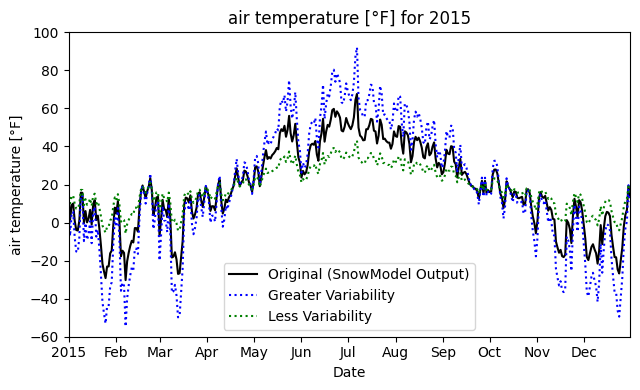

In [8]:
def plot_variable_for_year(year, variable):
    """
    Plots the specified variable for the given year from the greater_variability, less_variability, and repartitioned datasets.

    Parameters:
    year (int): The year to plot.
    variable (str): The variable to plot.
    """
    # Convert to Fahrenheit if the variable is air temperature.
    if variable == 'air temperature [K]':
        nf = repartitioned[variable] * 9/5 - 459.67
        gv = temp_hi_var[variable] * 9/5 - 459.67
        lv = temp_lo_var[variable] * 9/5 - 459.67
        variable = 'air temperature [°F]'
    elif 'Precip' in variable:
        nf = repartitioned[variable]  / 86400 / 1000
        gv = prec_hi_var[variable]  / 86400 / 1000
        lv = prec_lo_var[variable]  / 86400 / 1000
        variable = variable.replace('m', 'mm').replace('s^-1', 'd^-1')
    else:
        raise ValueError("Unsupported variable. Only 'air temperature [K]' and precipitation variables are supported.")
    
    # Filter data for the specified year
    mask = repartitioned['DateTime'].dt.year == year
    dates = repartitioned.loc[mask, 'DateTime']

    fig, ax = plt.subplots(figsize=(6.5, 4))
    
    # Plot data from each dataset
    ax.plot(dates, nf.loc[mask], 'k-', label='Original (SnowModel Output)')
    ax.plot(dates, gv.loc[mask], 'b:', label='Greater Variability')
    ax.plot(dates, lv.loc[mask], 'g:', label='Less Variability')
    
    # Add labels, legend, and title
    ax.set_xlabel('Date')
    ax.set_ylabel(variable)
    ax.set_title(f'{variable} for {year}')
    ax.legend()
    
    # Use concise date formatter for x-axis
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
    # Set y-axis limits for air temperature
    if variable == 'air temperature [°F]':
        ax.set_ylim(-60, 100)

    # Clip the x-axis to the extents
    ax.set_xlim(dates.min(), dates.max())
    plt.tight_layout()
    plt.show()

# Example usage: Plotting air temperature for the year 2015
plot_variable_for_year(2015, 'air temperature [K]')

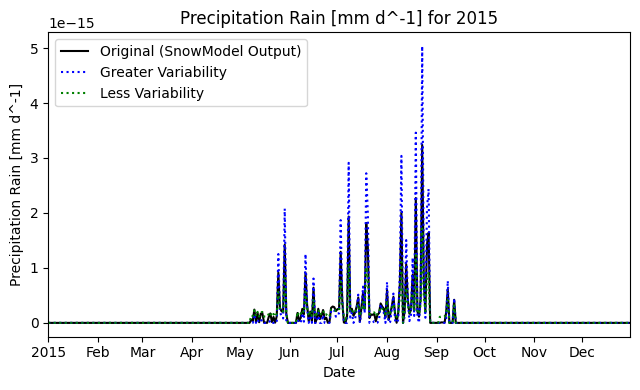

In [9]:
plot_variable_for_year(2015, 'Precipitation Rain [m s^-1]')

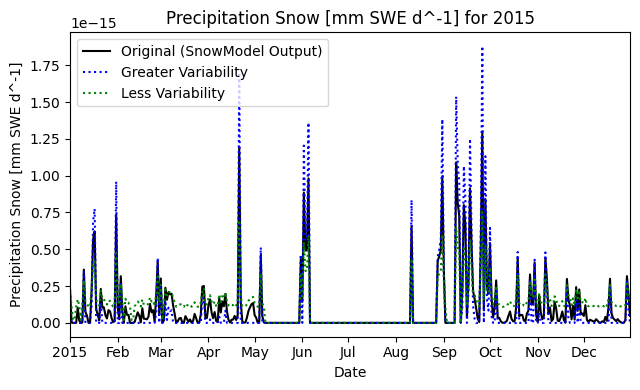

In [10]:
plot_variable_for_year(2015, 'Precipitation Snow [m SWE s^-1]')

In [ ]:
# Create copies of the HDF5 file with modified data
with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020.h5', 'r') as original_file:
    # Create control file
    with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020-control.h5', 'w') as control_file:
        for key in original_file.keys():
            if key in ['Precipitation Rain [m s^-1]', 'Precipitation Snow [m SWE s^-1]']:
                control_file.create_dataset(key, data=repartitioned[key])
            else:
                control_file.create_dataset(key, data=original_file[key][:])
    
    # Create low-variability temperature file
    with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020-temp-low-variability.h5', 'w') as temp_low_var_file:
        for key in original_file.keys():
            if key in ['air temperature [K]']:
                temp_low_var_file.create_dataset(key, data=temp_lo_var[key])
            else:
                temp_low_var_file.create_dataset(key, data=original_file[key][:])
    
    # Create high-variability temperature file
    with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020-temp-high-variability.h5', 'w') as temp_high_var_file:
        for key in original_file.keys():
            if key in ['air temperature [K]']:
                temp_high_var_file.create_dataset(key, data=temp_hi_var[key])
            else:
                temp_high_var_file.create_dataset(key, data=original_file[key][:])
    
    # Create low-variability precipitation file
    with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020-prec-low-variability.h5', 'w') as prec_low_var_file:
        for key in original_file.keys():
            if key in ['Precipitation Rain [m s^-1]', 'Precipitation Snow [m SWE s^-1]']:
                prec_low_var_file.create_dataset(key, data=prec_lo_var[key])
            else:
                prec_low_var_file.create_dataset(key, data=original_file[key][:])
    
    # Create high-variability precipitation file
    with h5py.File('capstone-projects/Devon_Hill/data/daac_ABoVE_snowmodel_data_2011_2020-prec-high-variability.h5', 'w') as prec_high_var_file:
        for key in original_file.keys():
            if key in ['Precipitation Rain [m s^-1]', 'Precipitation Snow [m SWE s^-1]']:
                prec_high_var_file.create_dataset(key, data=prec_hi_var[key])
            else:
                prec_high_var_file.create_dataset(key, data=original_file[key][:])